In [1]:
import warnings
warnings.filterwarnings("ignore")
from copy import deepcopy
from datetime import datetime
from pathlib import Path

import numpy as np
import pandas as pd
from tqdm import tqdm

from sklearn.utils import check_random_state

# implementing OPE of the IPWLearner using synthetic bandit data
from sklearn.linear_model import LogisticRegression, LinearRegression

import matplotlib.pyplot as plt

from scipy.special import softmax


from models import (    
    NeighborhoodModel,
    RegressionModel
)

from estimators import (
    DirectMethod as DM,
)

from simulation_utils import (
    eval_policy,
    generate_dataset,
    create_simulation_data_from_pi,
    get_train_data,
)


random_state=12345
random_ = check_random_state(random_state)

Using device: cpu
Using device: cpu


In [2]:
def calc_reward(dataset, policy):
    return np.array([np.sum(dataset['q_x_a'] * policy.squeeze(), axis=1).mean()])

In [3]:
pd.options.display.float_format = '{:,.4f}'.format

In [4]:
def get_ope_results_dict(reg_results, conv_results):
    reward = conv_results[:, 0]
    return dict(
                policy_rewards=reward.mean(),
                ipw=np.mean(abs(conv_results[: ,3] - reward)),
                reg_dm=np.mean(abs(reg_results - reward)),
                conv_dm=np.mean(abs(conv_results[: ,1] - reward)),
                conv_dr=np.mean(abs(conv_results[: ,2] - reward)),
                conv_sndr=np.mean(abs(conv_results[: ,4] - reward)),
                
                ipw_p_err=np.mean(abs(conv_results[: ,3] - reward) / reward) * 100,
                reg_dm_p_err=np.mean(abs(reg_results - reward) / reward) * 100,
                conv_dm_p_err=np.mean(abs(conv_results[: ,1] - reward) / reward) * 100,
                conv_dr_p_err=np.mean(abs(conv_results[: ,2] - reward) / reward) * 100,
                conv_sndr_p_err=np.mean(abs(conv_results[: ,4] - reward) / reward) * 100,
                
                ipw_var=np.std(conv_results[: ,3]),
                reg_dm_var=np.std(reg_results),
                conv_dm_var=np.std(conv_results[: ,1]),
                conv_dr_var=np.std(conv_results[: ,2]),
                conv_sndr_var=np.std(conv_results[: ,4]),
                )

In [5]:
def plot_results(df):
    fig, ax = plt.subplots(figsize=(10, 5))
    for val in ["ipw", "reg_dm", "conv_dm", "conv_dr", "conv_sndr"]:
        ci = df[val + '_var']
        ax.plot(df.index, df[val], label=val)
        ax.fill_between(df.index, (df[val]-ci), (df[val]+ci), alpha=.1, linestyle='--')


    plt.xlabel("Number of training data")
    plt.ylabel("Policy value error")
    plt.title("IPW vs DM vs DR vs SNDR Errors")
    plt.legend()
    plt.show()
    plt.clf()
    
    df.plot(
    y=["ipw_p_err", "reg_dm_p_err", "conv_dm_p_err", "conv_dr_p_err", "conv_sndr_p_err"],
    title="IPW vs DM vs DR vs SNDR Errors in percentage",
    xlabel="Number of training data",
    figsize=(10, 5),
    marker="o",
    )
    plt.show()
    plt.clf()

In [6]:
result_path = Path(f"./result/{datetime.now().strftime('%Y-%m-%d')}/train_data")
result_path.mkdir(parents=True, exist_ok=True)
result_file_name = f"result_{datetime.now().strftime('%H:00')}.csv"
curve_file_name = f"curve_{datetime.now().strftime('%H:00')}.csv"
print(result_file_name)

result_19:00.csv


## OPE

We will run several simulations on a generated dataset, the dataset is generated like this:
$$ \text{We have users U and actions A } u_i \sim N(0, I_{emb_dim}) \ a_i \sim N(0, I_{emb_dim})$$
$$ p_{ij} = 1 / (5 + e^{-(u_i.T a_j)}) $$
$$r_{ij} \sim Bin(p_{ij})$$

We have a policy $\pi$
and it's ground truth reward is calculated by
$$R_{gt} = \sum_{i}{\sum_{j}{\pi_{ij} * p_{ij}}} $$

In [7]:
def no_learning_trial(
                      dataset,
                      num_runs, 
                      num_neighbors, 
                      train_sizes, 
                      val_size=2000
                      ):
    results = {}
    dm = DM()
    our_x, our_a, n_actions = dataset["our_x"], dataset["our_a"], dataset["n_actions"]

    for train_size in train_sizes:
        reg_results, conv_results = [], []
        for run in range(num_runs):
            
            randsamp = np.ones_like(dataset["q_x_a"])/(dataset["n_actions"])
            pi_0 = softmax(our_x @ our_a.T, axis=1)

            pi_0 = 0.8 * pi_0 + 0.2 * randsamp
            original_policy_prob = np.expand_dims(pi_0, -1)

            simulation_data = create_simulation_data_from_pi(
                dataset, pi_0, train_size+val_size, random_state=0
            )
            
            # test_data = get_test_data(dataset, simulation_data, n_test_data)
            
            # idx = np.arange(train_size) + n_test_data
            idx_train = np.arange(train_size)
            train_data = get_train_data(n_actions, train_size, simulation_data, idx_train, our_x)
            val_idx   = np.arange(val_size) + train_size
            val_data  = get_train_data(n_actions, val_size, simulation_data, val_idx, our_x)
            
            regression_model = RegressionModel(
                                                n_actions=n_actions,
                                                action_context=our_x,
                                                base_model=LogisticRegression(random_state=12345)
                                                )
            
            neighberhoodmodel = NeighborhoodModel(
                                                    train_data['x_idx'],
                                                    train_data['a'], 
                                                    our_a,
                                                    our_x, 
                                                    train_data['r'], 
                                                    num_neighbors=num_neighbors
                                                )
            
            original_policy_prob = np.expand_dims(pi_0, -1)
            regression_model.fit(train_data['x'], train_data['a'], train_data['r'], original_policy_prob[train_data['x_idx'], train_data['a']].squeeze())
            
            policy = np.expand_dims(softmax(our_x @ our_a.T, axis=1), -1)

            # reg_dm = dm.estimate_policy_value(policy[test_data['x_idx']], regression_model.predict(test_data['x']))
            reg_dm = dm.estimate_policy_value(policy[val_data['x_idx']], regression_model.predict(val_data['x']))

            reg_results.append(reg_dm)

            # conv_results.append(eval_policy(neighberhoodmodel, test_data, original_policy_prob[test_data['x_idx']], policy))
            conv_results.append(eval_policy(neighberhoodmodel, val_data, original_policy_prob[val_data['x_idx']], policy))
            conv_results[-1] = np.append(calc_reward(dataset, policy), conv_results[-1])

        reg_results = np.array(reg_results)
        conv_results = np.array(conv_results)

        results[train_size] = get_ope_results_dict(reg_results, conv_results)
        
    return pd.DataFrame.from_dict(results, orient='index')

In [11]:
dataset_params = dict(
                    n_actions= 500,
                    n_users = 500,
                    emb_dim = 16,
                    # sigma = 0.1,
                    eps = 0.6, # this is the epsilon for the noise in the ground truth policy representation
                    ctr = 0.1
                    )

dataset = generate_dataset(dataset_params)

Random Item CTR: 0.07066414727263938
Optimal greedy CTR: 0.09999926940951757
Optimal Stochastic CTR: 0.09995326955796031
Our Initial CTR: 0.08610747363354625


In [12]:
# num_rounds_list = [3]
num_rounds_list = [1000, 2000, 3000, 4000, 5000, 10000, 20000]

# num_runs = 5 # number of simulations
max_iter = 25 # number of epochs

In [ ]:
# dm = DM()
# results = {}
num_runs = 10
batch_size = 50
num_neighbors = 8
# num_rounds_list = [3, 5]

We start with the parameters:
$$EmbDim = 5$$
$$NumActions= 150$$
$$NumUsers = 150$$
$$NeighborhoodSize = 6$$
and we run 10 trials for stability and variance calculation


To test the policy $\pi$
We will use an initial policy : $$\pi_{start} = (1-\epsilon)*\pi + \epsilon * random$$ to sample examples from the data
and then use ope tools and the convolution model to calculate $\hat{R}$

#### Initial Noised Policy
This is the first policy we will test out, the policy is:

$$emb = 0.8 * gt + 0.2 * noise$$

In [17]:
df1 = no_learning_trial(dataset, num_runs, num_neighbors, num_rounds_list)

In [18]:
df1

,policy_rewards,ipw,reg_dm,conv_dm,conv_dr,conv_sndr,ipw_p_err,reg_dm_p_err,conv_dm_p_err,conv_dr_p_err,conv_sndr_p_err,ipw_var,reg_dm_var,conv_dm_var,conv_dr_var,conv_sndr_var
1000,0.0861,0.0297,0.0008,0.0100,0.0117,0.0119,34.5239,0.9390,11.6171,13.5841,13.8433,0.0000,0.0000,0.0000,0.0000,0.0000
2000,0.0861,0.0002,0.0036,0.0044,0.0018,0.0014,0.2217,4.2254,5.0876,2.1191,1.6239,0.0000,0.0000,0.0000,0.0000,0.0000
3000,0.0861,0.0441,0.0015,0.0046,0.0411,0.0535,51.1590,1.7043,5.3415,47.7599,62.1201,0.0000,0.0000,0.0000,0.0000,0.0000
4000,0.0861,0.0248,0.0076,0.0076,0.0050,0.0043,28.7741,8.7764,8.7862,5.8341,4.9733,0.0000,0.0000,0.0000,0.0000,0.0000
5000,0.0861,0.0194,0.0082,0.0116,0.0170,0.0184,22.5742,9.5581,13.4323,19.7831,21.3355,0.0000,0.0000,0.0000,0.0000,0.0000
10000,0.0861,0.0406,0.0011,0.0037,0.0420,0.0475,47.1359,1.3090,4.3080,48.8257,55.1460,0.0000,0.0000,0.0000,0.0000,0.0000
20000,0.0861,0.0119,0.0037,0.0003,0.0139,0.0183,13.8610,4.2537,0.3277,16.1395,21.2628,0.0000,0.0000,0.0000,0.0000,0.0000


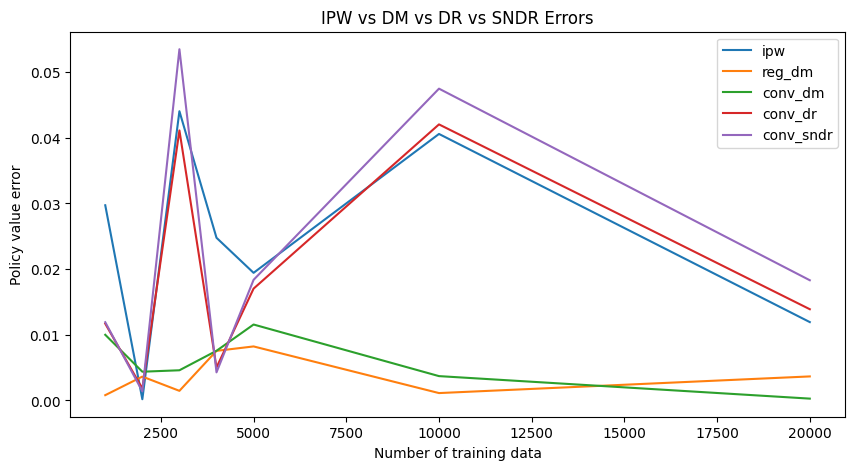

<Figure size 640x480 with 0 Axes>

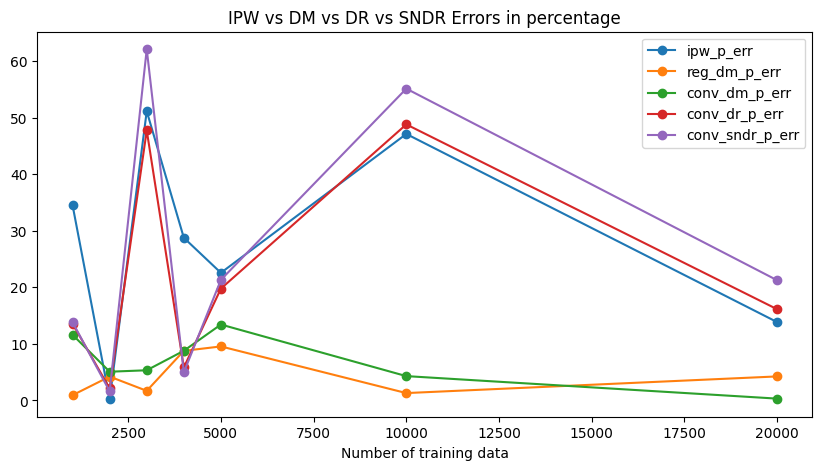

<Figure size 640x480 with 0 Axes>

In [19]:
plot_results(df1)

#### Optimal policy

$$emb = gt

In [20]:
temp_data = dataset.copy()
temp_data['our_a'] = dataset["emb_a"]
temp_data['our_x'] = dataset["emb_x"]

In [22]:
df2 = no_learning_trial(temp_data, num_runs, num_neighbors, num_rounds_list)

In [23]:
df2

,policy_rewards,ipw,reg_dm,conv_dm,conv_dr,conv_sndr,ipw_p_err,reg_dm_p_err,conv_dm_p_err,conv_dr_p_err,conv_sndr_p_err,ipw_var,reg_dm_var,conv_dm_var,conv_dr_var,conv_sndr_var
1000,0.1000,0.0139,0.0026,0.0158,2.5688,0.0108,13.9279,2.5628,15.8288,"2,570.0435",10.7632,0.0000,0.0000,0.0000,0.0000,0.0000
2000,0.1000,0.0135,0.0038,0.0010,6.8332,0.0153,13.4901,3.8373,1.0213,"6,836.4179",15.3152,0.0000,0.0000,0.0000,0.0000,0.0000
3000,0.1000,0.0066,0.0022,0.0046,5.5492,0.0070,6.5766,2.2077,4.6129,"5,551.7969",7.0128,0.0000,0.0000,0.0000,0.0000,0.0000
4000,0.1000,0.0053,0.0047,0.0020,7.3541,0.0170,5.3290,4.6856,1.9654,"7,357.5509",17.0429,0.0000,0.0000,0.0000,0.0000,0.0000
5000,0.1000,0.0012,0.0049,0.0157,9.1124,0.0031,1.2215,4.9328,15.6925,"9,116.6739",3.0966,0.0000,0.0000,0.0000,0.0000,0.0000
10000,0.1000,0.0060,0.0058,0.0005,1.0358,0.0026,5.9950,5.7608,0.4934,"1,036.2390",2.6090,0.0000,0.0000,0.0000,0.0000,0.0000
20000,0.1000,0.0020,0.0053,0.0010,7.5419,0.0150,1.9754,5.3301,0.9687,"7,545.3801",15.0119,0.0000,0.0000,0.0000,0.0000,0.0000


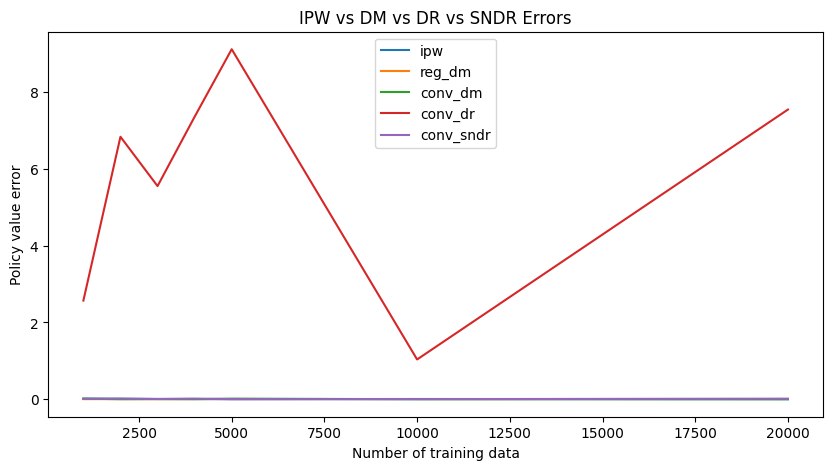

<Figure size 640x480 with 0 Axes>

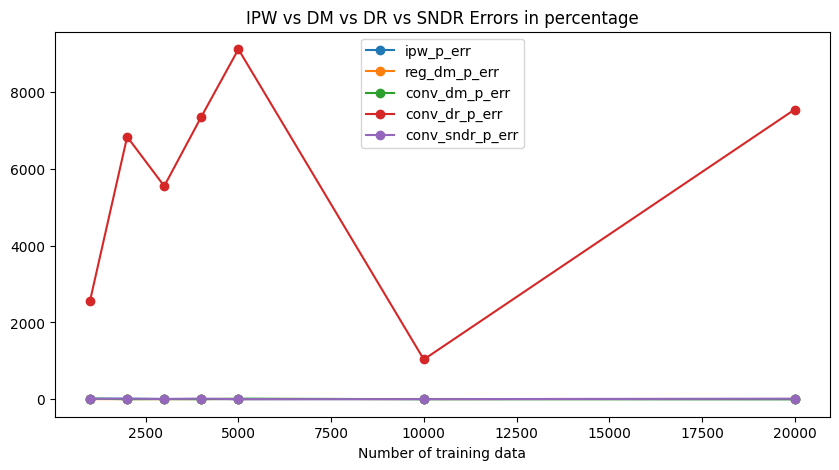

<Figure size 640x480 with 0 Axes>

In [24]:
plot_results(df2)

#### Random Policy

$$emb = noise$$

In [25]:
new_x = random_.normal(size=(dataset_params["n_users"], dataset_params["emb_dim"]))
new_a = random_.normal(size=(dataset_params["n_actions"], dataset_params["emb_dim"]))

temp_data['our_a'] = new_a
temp_data['our_x'] = new_x

In [26]:
df3 = no_learning_trial(temp_data, num_runs, num_neighbors, num_rounds_list)

In [27]:
df3

,policy_rewards,ipw,reg_dm,conv_dm,conv_dr,conv_sndr,ipw_p_err,reg_dm_p_err,conv_dm_p_err,conv_dr_p_err,conv_sndr_p_err,ipw_var,reg_dm_var,conv_dm_var,conv_dr_var,conv_sndr_var
1000,0.0689,0.0066,0.0004,0.0049,1.5080,0.0085,9.5838,0.6344,7.1519,"2,188.9605",12.3669,0.0000,0.0000,0.0000,0.0000,0.0000
2000,0.0689,0.0149,0.0018,0.0028,3.3400,0.0097,21.6984,2.5813,4.0429,"4,848.4448",14.0657,0.0000,0.0000,0.0000,0.0000,0.0000
3000,0.0689,0.0092,0.0025,0.0069,9.1109,0.0112,13.2843,3.6671,9.9724,"13,225.5449",16.2284,0.0000,0.0000,0.0000,0.0000,0.0000
4000,0.0689,0.0029,0.0011,0.0051,0.1501,0.0048,4.2714,1.6658,7.3951,217.8260,6.9424,0.0000,0.0000,0.0000,0.0000,0.0000
5000,0.0689,0.0028,0.0034,0.0061,2.7880,0.0126,4.1263,4.9263,8.8426,"4,047.0734",18.3185,0.0000,0.0000,0.0000,0.0000,0.0000
10000,0.0689,0.0125,0.0000,0.0052,0.0684,0.0051,18.0936,0.0240,7.6162,99.2535,7.4084,0.0000,0.0000,0.0000,0.0000,0.0000
20000,0.0689,0.0165,0.0027,0.0010,6.8961,0.0145,23.8832,3.9876,1.4786,"10,010.3861",21.0843,0.0000,0.0000,0.0000,0.0000,0.0000


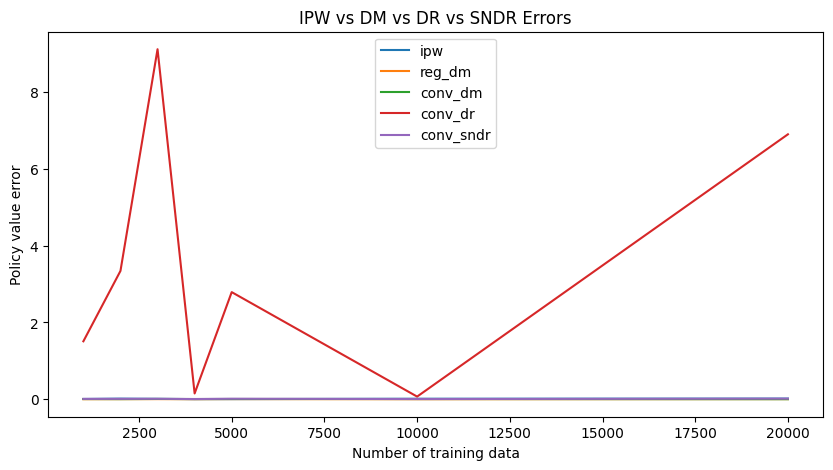

<Figure size 640x480 with 0 Axes>

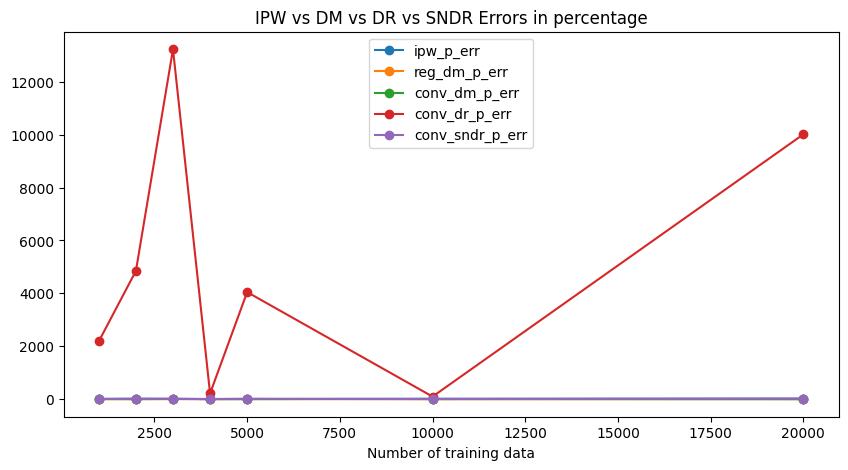

<Figure size 640x480 with 0 Axes>

In [28]:
plot_results(df3)

#### Iterative improvement
At each iteration the model embeddings get closer to the ground truth - $$emb = (1-\epsilon_t) * gt + \epsilon_t * noise$$

In [29]:
df_iterative_improvment = df3.iloc[5:].copy()
df_iterative_improvment['noise level'] = 10

for i in range(1, 11):
    temp_data['our_a'] = ((10-i) * new_a + i * dataset["emb_a"]) /10
    temp_data['our_x'] = ((10-i) * new_x + i * dataset["emb_x"]) /10

    rounds = [num_rounds_list[-1]]
    df = no_learning_trial(temp_data, num_runs, num_neighbors, rounds)
    df['noise level'] = 10 - i
    df_iterative_improvment = pd.concat([df_iterative_improvment, df])

In [30]:
keys_for_display = ['noise level', 'policy_rewards', 
                    'ipw', 'reg_dm', 'conv_dm', 'conv_dr', 'conv_sndr',
                    'ipw_var', 'reg_dm_var', 'conv_dm_var', 'conv_dr_var', 'conv_sndr_var']

In [31]:
df_iterative_improvment.iloc[1:][keys_for_display[1:]]

,policy_rewards,ipw,reg_dm,conv_dm,conv_dr,conv_sndr,ipw_var,reg_dm_var,conv_dm_var,conv_dr_var,conv_sndr_var
20000,0.0689,0.0165,0.0027,0.0010,6.8961,0.0145,0.0000,0.0000,0.0000,0.0000,0.0000
20000,0.0705,0.0123,0.0037,0.0042,0.3679,0.0053,0.0000,0.0000,0.0000,0.0000,0.0000
20000,0.0741,0.0047,0.0027,0.0014,0.3375,0.0033,0.0000,0.0000,0.0000,0.0000,0.0000
20000,0.0792,0.0185,0.0017,0.0014,1.9952,0.0137,0.0000,0.0000,0.0000,0.0000,0.0000
20000,0.0850,0.0193,0.0054,0.0088,4.9600,0.0359,0.0000,0.0000,0.0000,0.0000,0.0000
20000,0.0907,0.0164,0.0040,0.0023,1.5033,0.0150,0.0000,0.0000,0.0000,0.0000,0.0000
20000,0.0954,0.0189,0.0061,0.0007,2.3161,0.0292,0.0000,0.0000,0.0000,0.0000,0.0000
20000,0.0982,0.0106,0.0059,0.0007,1.9655,0.0232,0.0000,0.0000,0.0000,0.0000,0.0000
20000,0.0994,0.0202,0.0063,0.0062,1.0742,0.0009,0.0000,0.0000,0.0000,0.0000,0.0000
20000,0.0998,0.0026,0.0061,0.0015,2.3841,0.0099,0.0000,0.0000,0.0000,0.0000,0.0000


In [32]:
df_iterative_improvment.set_index('noise level', inplace=True)

<Axes: title={'center': 'IPW vs DM vs DR vs SNDR Errors'}, xlabel='noise level'>

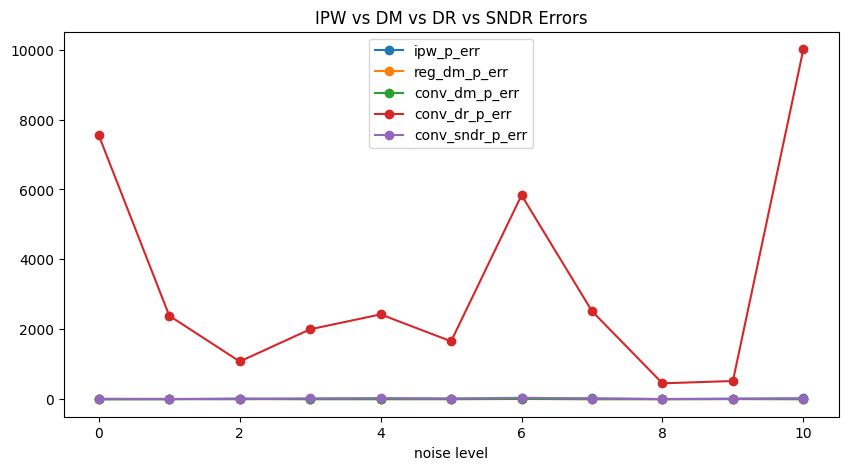

In [33]:
df_iterative_improvment.iloc[1:].plot(
    y=["ipw_p_err",	"reg_dm_p_err",	"conv_dm_p_err", "conv_dr_p_err", "conv_sndr_p_err"],
    title="IPW vs DM vs DR vs SNDR Errors",
    figsize=(10, 5),
    marker="o",
)